# Grandes cidades brasileiras são progressistas?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
import geopandas as gpd
import glob

from pandas.plotting import table 
from IPython.display import HTML
from unidecode import unidecode

%matplotlib inline

# Prefeitos eleitos entre 2004-2020

In [33]:
all_files = glob.glob('input/tse/prefeitos_eleitos/*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename).drop(['Unnamed: 0'],axis=1)
    li.append(df)

df = pd.concat(li).reset_index(drop=True)

Renomear partidos antigos

In [34]:
df.sigla_partido.replace('PRN','PTC', inplace=True)
df.sigla_partido.replace('PPB','PP', inplace=True)
df.sigla_partido.replace('PFL','DEM', inplace=True)
df.sigla_partido.replace('PTN','PODE', inplace=True)
df.sigla_partido.replace('PT DO B','AVT', inplace=True)
df.sigla_partido.replace('PEN','PATRI', inplace=True)
df.sigla_partido.replace('PMDB','MDB', inplace=True)
df.sigla_partido.replace('PSDC','DC', inplace=True)
df.sigla_partido.replace('PPS','CDD', inplace=True)
df.sigla_partido.replace('PR','PL', inplace=True)

df.sigla_partido.replace('REPUBLICANOS','PRB', inplace=True)
df.sigla_partido.replace('AVANTE','AVT', inplace=True)
df.sigla_partido.replace('CIDADANIA','CDD', inplace=True)
df.sigla_partido.replace('SOLIDARIEDADE','SD', inplace=True)
df.sigla_partido.replace('PATRIOTA','PATRI', inplace=True)

In [35]:
ano_da_eleicao = df.ano.unique().tolist()

# Mapa ideológico dos partidos

In [36]:
mapa_ideologico = {'PCB':'Esquerda',
                    'PT':'Esquerda',
                    'UP':'Esquerda',
                    'PSOL':'Esquerda',
                    'PSTU':'Esquerda',
                    'PC DO B':'Esquerda',
                    'PCO':'Esquerda',
                    'PDT':'Esquerda',
                    'REDE':'Esquerda',
                    'PSB':'Esquerda',
                    'PV':'Esquerda',
                    'SD':'Centro',
                    'PROS':'Centro',
                    'PTB':'Centro',
                    'PRB':'Centro',
                    'PP':'Centro',
                    'PMN':'Centro',
                    'PMB':'Centro',
                    'MDB':'Centro',
                    'PSDB':'Centro',
                    'CDD':'Centro',
                    'PSD':'Centro',
                    'DEM':'Direita',
                    'PL':'Direita',
                    'DC':'Direita',
                    'AVT':'Direita',
                    'PSC':'Direita',
                    'PODE':'Direita',
                    'PATRI':'Direita',
                    'NOVO':'Direita',
                    'PRTB':'Direita',
                    'PSL':'Direita',
                    'PTC':'Direita',
                    'PGT':'Esquerda',
                    'PST':'Esquerda',
                    'PHS':'Direita',
                    'PRP':'Direita',
                    'PPL':'Esquerda',
                    'PAN':'Centro',
                    'PRONA':'Direita'}

In [37]:
df['ideologia'] = df.sigla_partido.map(mapa_ideologico)

# Regiões e capitais

In [38]:
sigla_estado = {'AC':'Acre',
                'AL':'Alagoas',
                'AP':'Amapa',
                'AM':'Amazonas',
                'BA':'Bahia',
                'CE':'Ceara',
                'DF':'Distrito Federal',
                'ES':'Espirito Santo',
                'GO':'Goias',
                'MA':'Maranhao',
                'MT':'Mato Grosso',
                'MS':'Mato Grosso do Sul',
                'MG':'Minas Gerais',
                'PA':'Para',
                'PB':'Paraiba',
                'PR':'Parana',
                'PE':'Pernambuco',
                'PI':'Piaui',
                'RJ':'Rio de Janeiro',
                'RN':'Rio Grande do Norte',
                'RS':'Rio Grande do Sul',
                'RO':'Rondonia',
                'RR':'Roraima',
                'SC':'Santa Catarina',
                'SP':'Sao Paulo',
                'SE':'Sergipe',
                'TO':'Tocantins'}

In [39]:
capitais = {'AC':'Rio Branco',
            'AL':'Maceio',
            'AP':'Macapa',
            'AM':'Manaus',
            'BA':'Salvador',
            'CE':'Fortaleza',
            'DF':'Brasilia',
            'ES':'Vitoria',
            'GO':'Goiania',
            'MA':'Sao Luis',
            'MT':'Cuiaba',
            'MS':'Campo Grande',
            'MG':'Belo Horizonte',
            'PA':'Belem',
            'PB':'Joao Pessoa',
            'PR':'Curitiba',
            'PE':'Recife',
            'PI':'Teresina',
            'RJ':'Rio de Janeiro',
            'RN':'Natal',
            'RS':'Porto Alegre',
            'RO':'Porto Velho',
            'RR':'Boa Vista',
            'SC':'Florianopolis',
            'SP':'Sao Paulo',
            'SE':'Aracaju',
            'TO':'Palmas'}
capitais = dict((k.upper(), v.upper()) for k, v in capitais.items())

In [40]:
df['capitais'] = pd.Series(list(zip(df.sigla_unidade_federativa, df.nome_municipio))).isin(capitais.items())

In [41]:
regioes = {'Norte':['AC','AP','AM','PA','RO','RR','TO'],
           'Nordeste':['AL','BA','CE','MA','PB','PE','PI','RN','SE'],
           'Centro-Oeste':['GO','MT','MS'],
           'Sudeste':['ES','MG','RJ','SP'],
           'Sul':['PR','SC','RS']}

In [42]:
df['regiao'] = df.sigla_unidade_federativa.apply(lambda x: ''.join([k for k, v in regioes.items() if x in v]))

# Lista de população, tamanho e densidade por município

Obter lista da população, tamanho e densidade por município

In [43]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o_(2020)'
municipio_pop = pd.read_html(url, thousands=' ')[0]

# eliminar espaço para converter para int
municipio_pop['População'] = municipio_pop['População'].str.replace('\D', '').astype(int)

# converter estado e municipio para sem acentos e maiusculo
municipio_pop['Unidade federativa'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: unidecode(x))
municipio_pop['Município'] = municipio_pop['Município'].str.upper().apply(lambda x: unidecode(x))

# abreviar UF
municipio_pop['sigla_uf'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: [k for k, v in sigla_estado.items() if (unidecode(v.upper()) == x)])
municipio_pop = municipio_pop.explode('sigla_uf')

municipio_pop.drop('Posição', axis=1, inplace=True)
municipio_pop.set_index('Código IBGE', inplace=True)

In [44]:
url = 'https://pt.m.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente'
municipio_km = pd.read_html(url, thousands=' ')[0]

municipio_km['Área (km²)'] = municipio_km['Área (km²)'].str.replace(',','.').str.replace(u'\xa0', u'').astype(float)
municipio_km.drop(['Posição','Município', 'Unidade federativa'], axis=1, inplace=True)
municipio_km.rename(columns={'Código do IBGE':'Código IBGE'}, inplace=True)
municipio_km.set_index('Código IBGE', inplace=True)

In [45]:
density_label = ['0-5','5-10','10-20','20-50','50-100','100-200','200-20k']

def agrupar_por_densidade(den):
    if den >= 0 and den < 5:
        return 0
    elif den >= 5 and den < 10:
        return 1
    elif den >= 10 and den < 20:
        return 2
    elif den >= 20 and den < 50:
        return 3
    elif den >= 50 and den < 100:
        return 4
    elif den >= 100 and den < 200:
        return 5
    elif den >= 200 and den < 20000:
        return 6
    else:
        return 'other'
    
municipios = pd.merge(municipio_pop, municipio_km, on='Código IBGE')
municipios['densidade'] = municipios['População'] / municipios['Área (km²)']
municipios['grupo_densidade'] = municipios.apply(lambda x : agrupar_por_densidade(x.densidade), axis=1)

In [48]:
# Obter tabela de correspondencia entre codigo de municipio do IBGE e TSE
link = 'https://raw.githubusercontent.com/estadao/como-votou-sua-vizinhanca/master/data/votos/correspondencia-tse-ibge.csv'
df_equivalencia = pd.read_csv(link)
df_equivalencia.set_index('COD_TSE', drop=False, inplace=True)
df_equivalencia.drop(['chave','NOME','UF'], axis=1, inplace=True)

In [49]:
df.set_index('codigo_municipio', drop=False, inplace=True)
df = df.join(df_equivalencia)

In [50]:
df.set_index('GEOCOD_IBGE', drop=False, inplace=True)
df = df.join(municipios[['População','densidade','grupo_densidade']])

Latitude e Longitude

In [51]:
# Obter tabela latitude e longitude para municipios
link = 'https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv'
df_lat_long = pd.read_csv(link)
df_lat_long.set_index('codigo_ibge', inplace=True)
df_lat_long.drop(['nome','capital','codigo_uf'], axis=1, inplace=True)

In [52]:
df = df.join(df_lat_long)

# Evolução de prefeitos eleitos por partido

### Todos Municípios

In [457]:
res = df.groupby(['ano','sigla_partido']).count().iloc[:,0].reset_index() \
.pivot(index='sigla_partido', columns='ano', values='sigla_unidade_federativa') \
.sort_values(2020, ascending=False).fillna(0)

Preparar dataset para flourish

In [458]:
res.insert(0, 'ideologia', res.index.map(mapa_ideologico))
res.to_excel('output/flourish_prefeitos_municipios_total.xlsx')

Agrupar por ideologia dos partidos

In [459]:
r_esq = res[res.ideologia == 'Esquerda']
r_esq = r_esq.drop('ideologia', axis=1).T
r_esq = r_esq.fillna(0).astype(int)
r_esq.sort_values(r_esq.index[-1], axis=1, ascending=False, inplace=True)

r_centro = res[res.ideologia == 'Centro']
r_centro = r_centro.drop('ideologia', axis=1).T
r_centro = r_centro.fillna(0).astype(int)
r_centro.sort_values(r_centro.index[-1], axis=1, ascending=False, inplace=True)

r_dir = res[res.ideologia == 'Direita']
r_dir = r_dir.drop('ideologia', axis=1).T
r_dir = r_dir.fillna(0).astype(int)
r_dir.sort_values(r_dir.index[-1], axis=1, ascending=False, inplace=True)

In [460]:
def max_size(column_lenght, max_size=5):
    if column_lenght > max_size:
        size = max_size
    else:
        size = column_lenght
    return size

def draw_subplots(axs, r_esq, r_centro, r_dir, labels=4):
    l_esq = sns.lineplot(data=r_esq, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='Reds_r', ax=axs[0])
    l_centro = sns.lineplot(data=r_centro, dashes=False, legend=False, linewidth=5, marker='o',
                 markersize=15, palette='YlOrBr_r', ax=axs[1])
    l_dir = sns.lineplot(data=r_dir, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='Blues_r', ax=axs[2])

    axs[0].set_title('Esquerda', loc='left', fontsize=20, fontweight='bold', color='grey')
    axs[1].set_title('Centro', loc='left', fontsize=20, fontweight='bold', color='grey')
    axs[2].set_title('Direita', loc='left', fontsize=20, fontweight='bold', color='grey')  

    axs[0].set_xlabel('')
    axs[1].set_xlabel('')
    axs[2].set_xlabel('')
    
    axs[0].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
    axs[1].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
    axs[2].set_ylabel('Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
  
    axs[0].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    axs[1].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    axs[2].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
    
    axs[0].set_xticklabels(labels=[int(i) for i in axs[0].get_xticks()], fontsize=15, color='grey')
    axs[1].set_xticklabels(labels=[int(i) for i in axs[1].get_xticks()], fontsize=15, color='grey')
    axs[2].set_xticklabels(labels=[int(i) for i in axs[2].get_xticks()], fontsize=15, color='grey')
    
    axs[0].set_yticklabels(labels=[int(i) for i in axs[0].get_yticks()], fontsize=15, color='grey')
    axs[1].set_yticklabels(labels=[int(i) for i in axs[1].get_yticks()], fontsize=15, color='grey')
    axs[2].set_yticklabels(labels=[int(i) for i in axs[2].get_yticks()], fontsize=15, color='grey')
    
    axs[0].spines['bottom'].set_color('grey')
    axs[0].spines['left'].set_color('grey')
    axs[1].spines['bottom'].set_color('grey')
    axs[1].spines['left'].set_color('grey') 
    axs[2].spines['bottom'].set_color('grey')
    axs[2].spines['left'].set_color('grey')     

    for i in range(max_size(len(axs[0].get_lines()),labels)):
        axs[0].text(r_esq.index[-1]+.2, r_esq.iloc[-1,i], r_esq.columns[i],
                    fontsize=15, fontweight='bold', color=axs[0].get_lines()[i].get_color())

    for i in range(max_size(len(axs[0].get_lines()),5)):
        axs[1].text(r_centro.index[-1]+.2, r_centro.iloc[-1,i], r_centro.columns[i],
                    fontsize=15, fontweight='bold', color=axs[1].get_lines()[i].get_color())

    for i in range(max_size(len(axs[0].get_lines()),3)):
        axs[2].text(r_dir.index[-1]+.2, r_dir.iloc[-1,i], r_dir.columns[i],
                    fontsize=15, fontweight='bold', color=axs[2].get_lines()[i].get_color())
        
    axs[0].axvline(2005, color='grey', linestyle='--')
    axs[0].axvline(2013, color='grey', linestyle='--')
    axs[0].axvline(2014, color='grey', linestyle='--')
    axs[0].axvline(2016, color='grey', linestyle='--')

    axs[1].axvline(2005, color='grey', linestyle='--')
    axs[1].axvline(2013, color='grey', linestyle='--')
    axs[1].axvline(2014, color='grey', linestyle='--')
    axs[1].axvline(2016, color='grey', linestyle='--')
    
    axs[2].axvline(2005, color='grey', linestyle='--')
    axs[2].axvline(2013, color='grey', linestyle='--')
    axs[2].axvline(2014, color='grey', linestyle='--')
    axs[2].axvline(2016, color='grey', linestyle='--')

    axs[0].text(0.102, 0.99, 'Mensalão', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.557, 0.99, 'Manifestações', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.615, 0.99, 'Lava Jato', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')
    axs[0].text(0.727, 0.99, 'Impeachment', transform=axs[0].transAxes, rotation=-90,
                fontsize=15, color='dimgrey', verticalalignment='top')

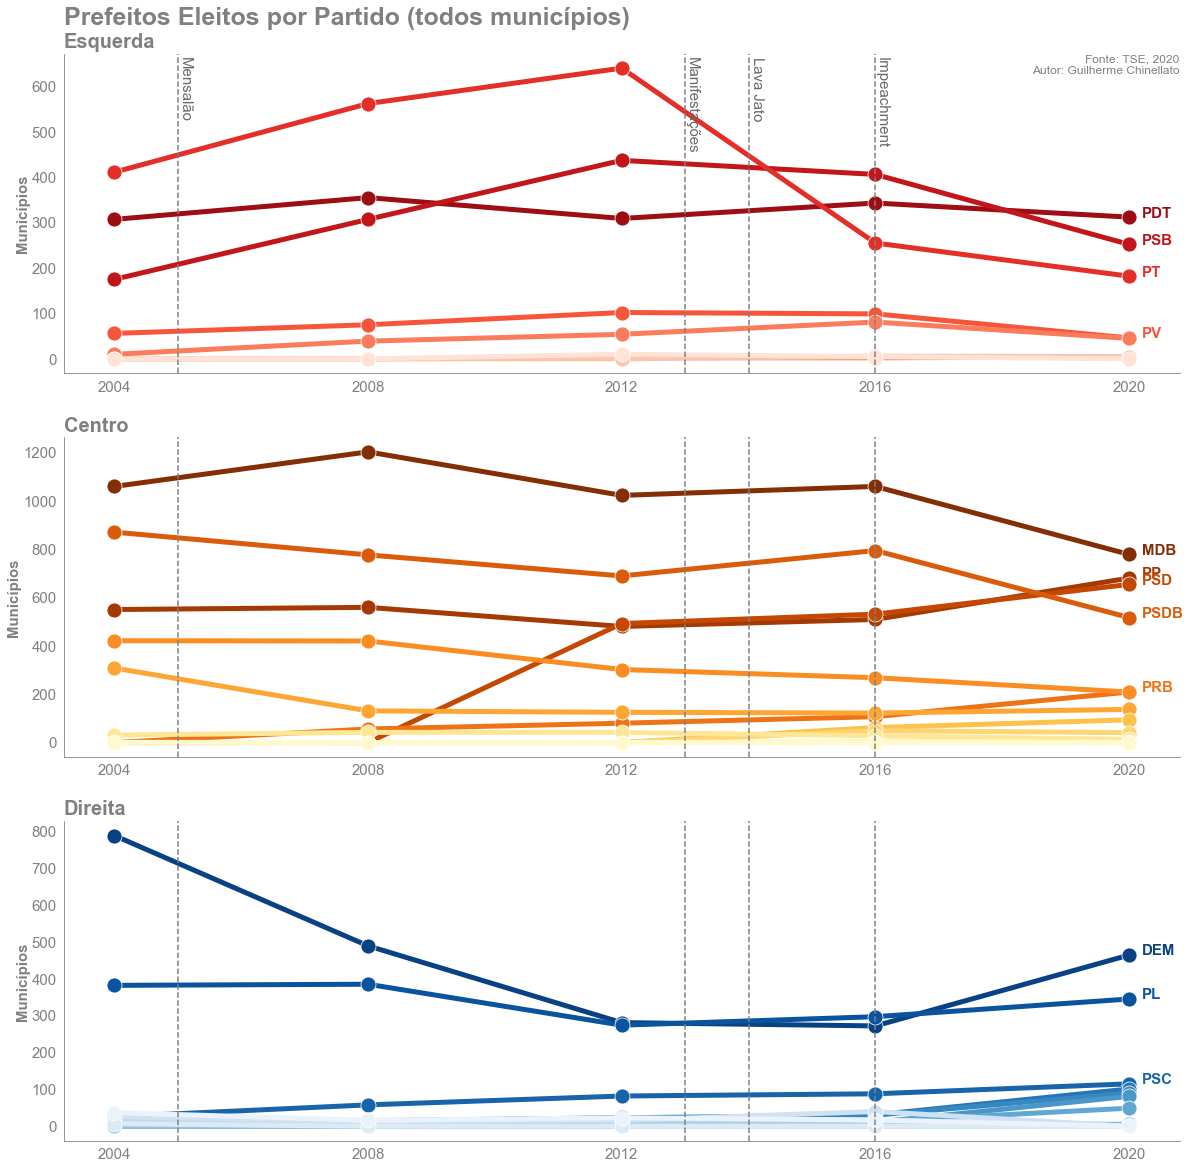

In [461]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('white')
sns.despine()

title = 'Prefeitos Eleitos por Partido (todos municípios)'
legend = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))

plt.text(x=0.125, y=0.9, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)
axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

draw_subplots(axs, r_esq, r_centro, r_dir) 

plt.savefig('output/prefeitos_partido_total.png', dpi=300, bbox_inches = 'tight')

Resultado agregado

In [462]:
agg_total = res.groupby('ideologia').sum().T
agg_total = agg_total[['Esquerda','Centro','Direita']]

agg_total_var = agg_total.pct_change().stack().reset_index()
agg_total_var.columns = ['Ano','Ideologia', 'Variação']

agg_total

ideologia,Esquerda,Centro,Direita
ano,,,
2004,959.0,3240.0,1360.0
2008,1338.0,3186.0,1033.0
2012,1554.0,3232.0,781.0
2016,1197.0,3533.0,834.0
2020,847.0,3333.0,1253.0


### Capitais

In [468]:
res_capitais = df[df.capitais == True].groupby(['ano','sigla_partido']).count().iloc[:,0].reset_index() \
.pivot(index='sigla_partido', columns='ano', values='sigla_unidade_federativa') \
.sort_values(2020, ascending=False).fillna(0)

In [469]:
res_capitais.insert(0, 'ideologia', res_capitais.index.map(mapa_ideologico))
res_capitais.to_excel('output/flourish_prefeitos_municipios_capitais.xlsx')

Agrupar por ideologia dos partidos

In [470]:
r_esq_capitais = res_capitais[res_capitais.ideologia == 'Esquerda']
r_esq_capitais = r_esq_capitais.drop('ideologia', axis=1).T
r_esq_capitais = r_esq_capitais.fillna(0).astype(int)
r_esq_capitais.sort_values(r_esq_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_centro_capitais = res_capitais[res_capitais.ideologia == 'Centro']
r_centro_capitais = r_centro_capitais.drop('ideologia', axis=1).T
r_centro_capitais = r_centro_capitais.fillna(0).astype(int)
r_centro_capitais.sort_values(r_centro_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_dir_capitais = res_capitais[res_capitais.ideologia == 'Direita']
r_dir_capitais = r_dir_capitais.drop('ideologia', axis=1).T
r_dir_capitais = r_dir_capitais.fillna(0).astype(int)
r_dir_capitais.sort_values(r_dir_capitais.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [477]:
agg_capitais = res_capitais.groupby('ideologia').sum().T
agg_capitais = agg_capitais[['Esquerda','Centro','Direita']]

agg_capitais_var = agg_capitais.pct_change().stack().reset_index()
agg_capitais_var.columns = ['Ano','Ideologia', 'Variação']

agg_capitais

ideologia,Esquerda,Centro,Direita
ano,,,
2004,15.0,10.0,1.0
2008,12.0,13.0,1.0
2012,13.0,10.0,3.0
2016,8.0,16.0,2.0
2020,5.0,14.0,6.0


### Cidades Grandes: >500mil hab.

In [478]:
res_municipios_grandes = df[df['População'] >= 500000].groupby(['ano','sigla_partido']).count().iloc[:,0].reset_index() \
.pivot(index='sigla_partido', columns='ano', values='sigla_unidade_federativa') \
.sort_values(2020, ascending=False).fillna(0)

In [482]:
res_municipios_grandes.insert(0, 'ideologia', res_municipios_grandes.index.map(mapa_ideologico))
res_municipios_grandes.to_excel('output/flourish_prefeitos_municipios_grandes.xlsx')

Agrupar por ideologia dos partidos

In [484]:
r_esq_municipios_grandes = res_municipios_grandes[res_municipios_grandes.ideologia == 'Esquerda']
r_esq_municipios_grandes = r_esq_municipios_grandes.drop('ideologia', axis=1).T
r_esq_municipios_grandes = r_esq_municipios_grandes.fillna(0).astype(int)
r_esq_municipios_grandes.sort_values(r_esq_municipios_grandes.index[-1], axis=1, ascending=False, inplace=True)

r_centro_municipios_grandes = res_municipios_grandes[res_municipios_grandes.ideologia == 'Centro']
r_centro_municipios_grandes = r_centro_municipios_grandes.drop('ideologia', axis=1).T
r_centro_municipios_grandes = r_centro_municipios_grandes.fillna(0).astype(int)
r_centro_municipios_grandes.sort_values(r_centro_municipios_grandes.index[-1], axis=1, ascending=False, inplace=True)

r_dir_municipios_grandes = res_municipios_grandes[res_municipios_grandes.ideologia == 'Direita']
r_dir_municipios_grandes = r_dir_municipios_grandes.drop('ideologia', axis=1).T
r_dir_municipios_grandes = r_dir_municipios_grandes.fillna(0).astype(int)
r_dir_municipios_grandes.sort_values(r_dir_municipios_grandes.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [487]:
agg_municipios_grandes = res_municipios_grandes.groupby('ideologia').sum().T
agg_municipios_grandes = agg_municipios_grandes[['Esquerda','Centro','Direita']]

agg_municipios_grandes_var = agg_municipios_grandes.pct_change().stack().reset_index()
agg_municipios_grandes_var.columns = ['Ano','Ideologia', 'Variação']

agg_municipios_grandes

ideologia,Esquerda,Centro,Direita
ano,,,
2004,24.0,19.0,5.0
2008,19.0,25.0,4.0
2012,25.0,16.0,7.0
2016,10.0,31.0,7.0
2020,9.0,25.0,11.0


### Cidades Médias: >100mil e <500mil hab.

In [492]:
res_municipios_medios = df[(df['População'] >= 100000) & (df['População'] < 500000)].groupby(['ano','sigla_partido']).count().iloc[:,0].reset_index() \
.pivot(index='sigla_partido', columns='ano', values='sigla_unidade_federativa') \
.sort_values(2020, ascending=False).fillna(0)

In [493]:
res_municipios_medios.insert(0, 'ideologia', res_municipios_medios.index.map(mapa_ideologico))
res_municipios_medios.to_excel('output/flourish_prefeitos_municipios_medios.xlsx')

Agrupar por ideologia dos partidos

In [494]:
r_esq_municipios_medios = res_municipios_medios[res_municipios_medios.ideologia == 'Esquerda']
r_esq_municipios_medios = r_esq_municipios_medios.drop('ideologia', axis=1).T
r_esq_municipios_medios = r_esq_municipios_medios.fillna(0).astype(int)
r_esq_municipios_medios.sort_values(r_esq_municipios_medios.index[-1], axis=1, ascending=False, inplace=True)

r_centro_municipios_medios = res_municipios_medios[res_municipios_medios.ideologia == 'Centro']
r_centro_municipios_medios = r_centro_municipios_medios.drop('ideologia', axis=1).T
r_centro_municipios_medios = r_centro_municipios_medios.fillna(0).astype(int)
r_centro_municipios_medios.sort_values(r_centro_municipios_medios.index[-1], axis=1, ascending=False, inplace=True)

r_dir_municipios_medios = res_municipios_medios[res_municipios_medios.ideologia == 'Direita']
r_dir_municipios_medios = r_dir_municipios_medios.drop('ideologia', axis=1).T
r_dir_municipios_medios = r_dir_municipios_medios.fillna(0).astype(int)
r_dir_municipios_medios.sort_values(r_dir_municipios_medios.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [497]:
agg_municipios_medios = res_municipios_medios.groupby('ideologia').sum().T
agg_municipios_medios = agg_municipios_medios[['Esquerda','Centro','Direita']]

agg_municipios_medios_var = agg_municipios_medios.pct_change().stack().reset_index()
agg_municipios_medios_var.columns = ['Ano','Ideologia', 'Variação']

agg_municipios_medios

ideologia,Esquerda,Centro,Direita
ano,,,
2004,76.0,154.0,47.0
2008,102.0,136.0,39.0
2012,98.0,159.0,20.0
2016,56.0,180.0,41.0
2020,31.0,159.0,70.0


### Cidades Pequenas: <100mil hab.

In [499]:
res_municipios_pequenos = df[df['População'] < 100000].groupby(['ano','sigla_partido']).count().iloc[:,0].reset_index() \
.pivot(index='sigla_partido', columns='ano', values='sigla_unidade_federativa') \
.sort_values(2020, ascending=False).fillna(0)

In [500]:
res_municipios_pequenos.insert(0, 'ideologia', res_municipios_pequenos.index.map(mapa_ideologico))
res_municipios_pequenos.to_excel('output/flourish_prefeitos_municipios_pequenos.xlsx')

Agrupar por ideologia dos partidos

In [503]:
r_esq_municipios_pequenos = res_municipios_pequenos[res_municipios_pequenos.ideologia == 'Esquerda']
r_esq_municipios_pequenos = r_esq_municipios_pequenos.drop('ideologia', axis=1).T
r_esq_municipios_pequenos = r_esq_municipios_pequenos.fillna(0).astype(int)
r_esq_municipios_pequenos.sort_values(r_esq_municipios_pequenos.index[-1], axis=1, ascending=False, inplace=True)

r_centro_municipios_pequenos = res_municipios_pequenos[res_municipios_pequenos.ideologia == 'Centro']
r_centro_municipios_pequenos = r_centro_municipios_pequenos.drop('ideologia', axis=1).T
r_centro_municipios_pequenos = r_centro_municipios_pequenos.fillna(0).astype(int)
r_centro_municipios_pequenos.sort_values(r_centro_municipios_pequenos.index[-1], axis=1, ascending=False, inplace=True)

r_dir_municipios_pequenos = res_municipios_pequenos[res_municipios_pequenos.ideologia == 'Direita']
r_dir_municipios_pequenos = r_dir_municipios_pequenos.drop('ideologia', axis=1).T
r_dir_municipios_pequenos = r_dir_municipios_pequenos.fillna(0).astype(int)
r_dir_municipios_pequenos.sort_values(r_dir_municipios_pequenos.index[-1], axis=1, ascending=False, inplace=True)

Resultado agregado

In [506]:
agg_municipios_pequenos = res_municipios_pequenos.groupby('ideologia').sum().T
agg_municipios_pequenos = agg_municipios_pequenos[['Esquerda','Centro','Direita']]

agg_municipios_pequenos_var = agg_municipios_pequenos.pct_change().stack().reset_index()
agg_municipios_pequenos_var.columns = ['Ano','Ideologia', 'Variação']

agg_municipios_pequenos

ideologia,Esquerda,Centro,Direita
ano,,,
2004,859.0,3067.0,1308.0
2008,1217.0,3025.0,990.0
2012,1431.0,3057.0,754.0
2016,1131.0,3322.0,786.0
2020,807.0,3149.0,1172.0


# Evolução de prefeitos eleitos por ideologia do partido

In [512]:
col = ['Ano','Município','Esquerda','Centro','Direita']

r = pd.DataFrame()
for i, val in enumerate(ano_da_eleicao):    
    t = pd.DataFrame(columns=col)

    t['Ano'] = [val,val,val]
    t['Município'] = ['Grandes','Médios','Pequenos']

    t.iloc[0,2] = round((agg_municipios_grandes.loc[val,'Esquerda'] / agg_municipios_grandes.loc[val].sum())*100,2)
    t.iloc[0,3] = round((agg_municipios_grandes.loc[val,'Centro'] / agg_municipios_grandes.loc[val].sum())*100,2)
    t.iloc[0,4] = round((agg_municipios_grandes.loc[val,'Direita'] / agg_municipios_grandes.loc[val].sum())*100,2)

    t.iloc[1,2] = round((agg_municipios_medios.loc[val,'Esquerda'] / agg_municipios_medios.loc[val].sum())*100,2)
    t.iloc[1,3] = round((agg_municipios_medios.loc[val,'Centro'] / agg_municipios_medios.loc[val].sum())*100,2)
    t.iloc[1,4] = round((agg_municipios_medios.loc[val,'Direita'] / agg_municipios_medios.loc[val].sum())*100,2)

    t.iloc[2,2] = round((agg_municipios_pequenos.loc[val,'Esquerda'] / agg_municipios_pequenos.loc[val].sum())*100,2)
    t.iloc[2,3] = round((agg_municipios_pequenos.loc[val,'Centro'] / agg_municipios_pequenos.loc[val].sum())*100,2)
    t.iloc[2,4] =round((agg_municipios_pequenos.loc[val,'Direita'] / agg_municipios_pequenos.loc[val].sum())*100,2)
    
    r = r.append(t)
    
r.to_excel('output/flourish_prefeitos_ideologia_perc.xlsx')

In [557]:
perc_grandes = r[r['Município'] == 'Grandes'].set_index('Ano').drop('Município',1).astype(float)
perc_medios = r[r['Município'] == 'Médios'].set_index('Ano').drop('Município',1).astype(float)
perc_pequenos = r[r['Município'] == 'Pequenos'].set_index('Ano').drop('Município',1).astype(float)

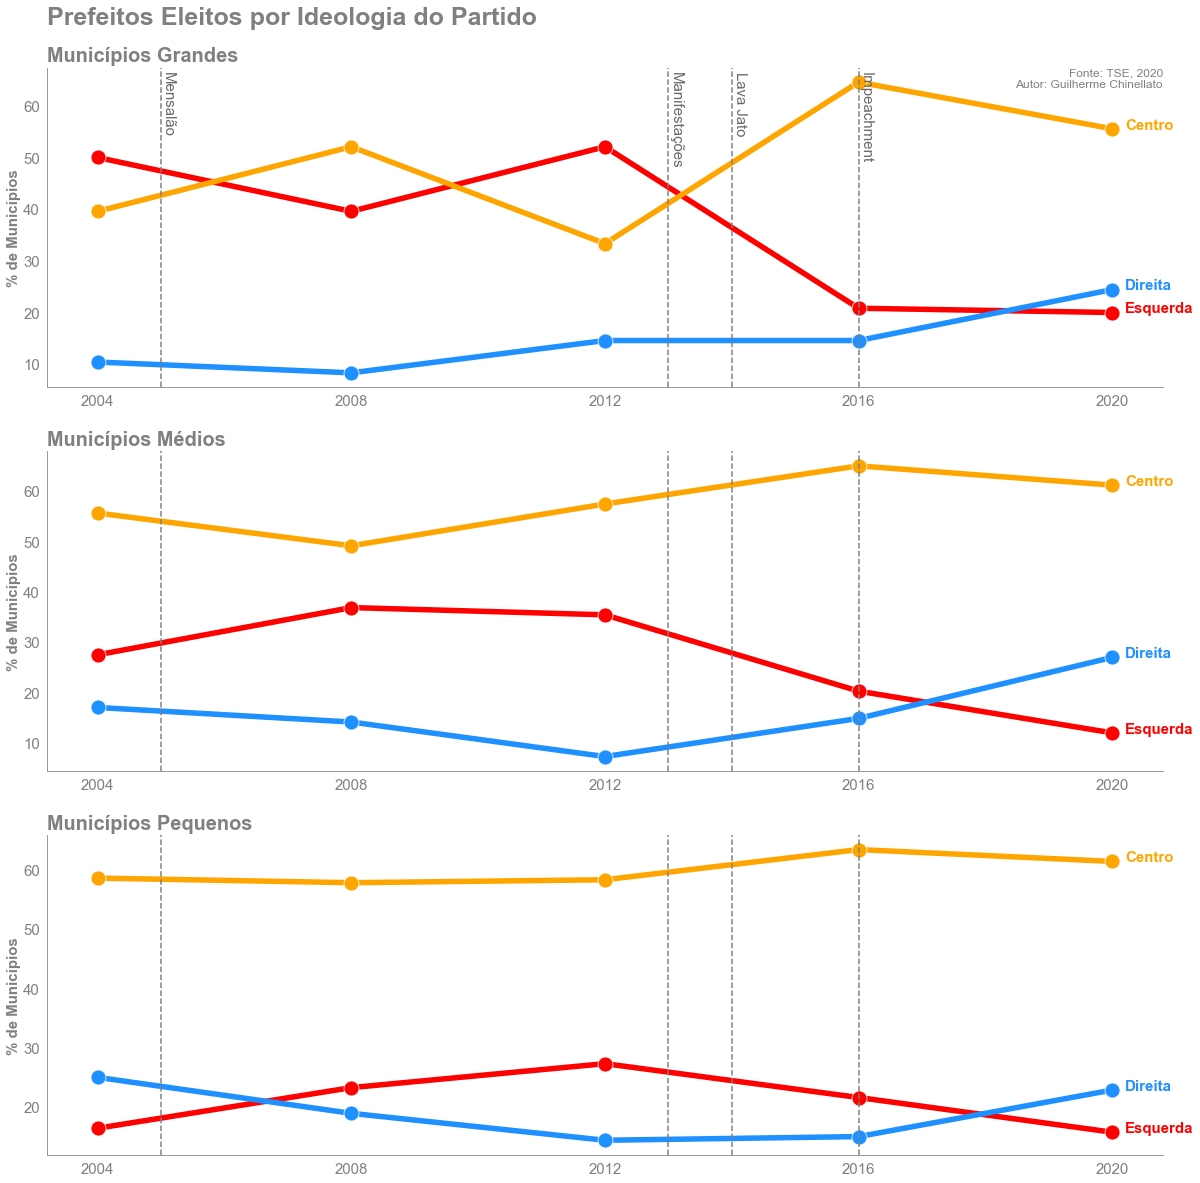

In [559]:
colors = ['red', 'orange', 'dodgerblue']

fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('white')
sns.despine()

title='Prefeitos Eleitos por Ideologia do Partido'
plt.text(x=0.125, y=0.91, s=title, fontsize=25, color='grey', fontweight='bold',
         transform=fig.transFigure)

l_grande = sns.lineplot(data=perc_grandes, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[0])
l_medio = sns.lineplot(data=perc_medios, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[1])
l_pequeno = sns.lineplot(data=perc_pequenos, dashes=False, legend=False, linewidth=5.5,
                       palette=colors, marker='o', markersize=15, ax=axs[2])

axs[0].set_title('Municípios Grandes', loc='left',
                 fontsize=20, fontweight='bold', color='grey')
axs[1].set_title('Municípios Médios', loc='left',
                 fontsize=20, fontweight='bold', color='grey')
axs[2].set_title('Municípios Pequenos', loc='left',
                 fontsize=20, fontweight='bold', color='grey')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

axs[0].set_ylabel('% de Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[1].set_ylabel('% de Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[2].set_ylabel('% de Municípios', labelpad=2, fontsize=15, fontweight='bold', color='grey')

axs[0].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
axs[1].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))
axs[2].set_xticks(np.arange(ano_da_eleicao[0], ano_da_eleicao[-1]+2, step=4))

axs[0].set_xticklabels(labels=[int(i) for i in axs[0].get_xticks()], fontsize=15, color='grey')
axs[1].set_xticklabels(labels=[int(i) for i in axs[1].get_xticks()], fontsize=15, color='grey')
axs[2].set_xticklabels(labels=[int(i) for i in axs[2].get_xticks()], fontsize=15, color='grey')

axs[0].set_yticklabels(labels=[int(i) for i in axs[0].get_yticks()], fontsize=15, color='grey')
axs[1].set_yticklabels(labels=[int(i) for i in axs[1].get_yticks()], fontsize=15, color='grey')
axs[2].set_yticklabels(labels=[int(i) for i in axs[2].get_yticks()], fontsize=15, color='grey')

axs[0].spines['bottom'].set_color('grey')
axs[0].spines['left'].set_color('grey')
axs[1].spines['bottom'].set_color('grey')
axs[1].spines['left'].set_color('grey') 
axs[2].spines['bottom'].set_color('grey')
axs[2].spines['left'].set_color('grey') 

#def flip(items, ncol):
#    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

#handles, labels = axs[0].get_legend_handles_labels()
#leg = l_grande.legend(flip(handles, 4), flip(labels, 4), loc=2, ncol=4, fontsize=15, borderaxespad=0.)    
#for line in leg.get_lines():
#    line.set_linewidth(5.5)

axs[0].text(1.0, 1.0, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

for i in range(len(axs[0].get_lines())):
    axs[0].text(perc_grandes.index[-1]+.2, perc_grandes.iloc[-1,i], perc_grandes.columns[i],
                fontsize=15, fontweight='bold', color=axs[0].get_lines()[i].get_color())

for i in range(len(axs[1].get_lines())):
    axs[1].text(perc_medios.index[-1]+.2, perc_medios.iloc[-1,i], perc_medios.columns[i],
                fontsize=15, fontweight='bold', color=axs[1].get_lines()[i].get_color())

for i in range(len(axs[2].get_lines())):
    axs[2].text(perc_pequenos.index[-1]+.2, perc_pequenos.iloc[-1,i], perc_pequenos.columns[i],
                fontsize=15, fontweight='bold', color=axs[2].get_lines()[i].get_color())

axs[0].axvline(2005, color='grey', linestyle='--')
axs[0].axvline(2013, color='grey', linestyle='--')
axs[0].axvline(2014, color='grey', linestyle='--')
axs[0].axvline(2016, color='grey', linestyle='--')

axs[1].axvline(2005, color='grey', linestyle='--')
axs[1].axvline(2013, color='grey', linestyle='--')
axs[1].axvline(2014, color='grey', linestyle='--')
axs[1].axvline(2016, color='grey', linestyle='--')

axs[2].axvline(2005, color='grey', linestyle='--')
axs[2].axvline(2013, color='grey', linestyle='--')
axs[2].axvline(2014, color='grey', linestyle='--')
axs[2].axvline(2016, color='grey', linestyle='--')

axs[0].text(0.102, 0.99, 'Mensalão', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.557, 0.99, 'Manifestações', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.615, 0.99, 'Lava Jato', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')
axs[0].text(0.727, 0.99, 'Impeachment', transform=axs[0].transAxes, rotation=-90,
            fontsize=15, color='dimgrey', verticalalignment='top')

plt.savefig('output/prefeitos_ideologia.png', dpi=300, bbox_inches = 'tight')

Variação entre eleições

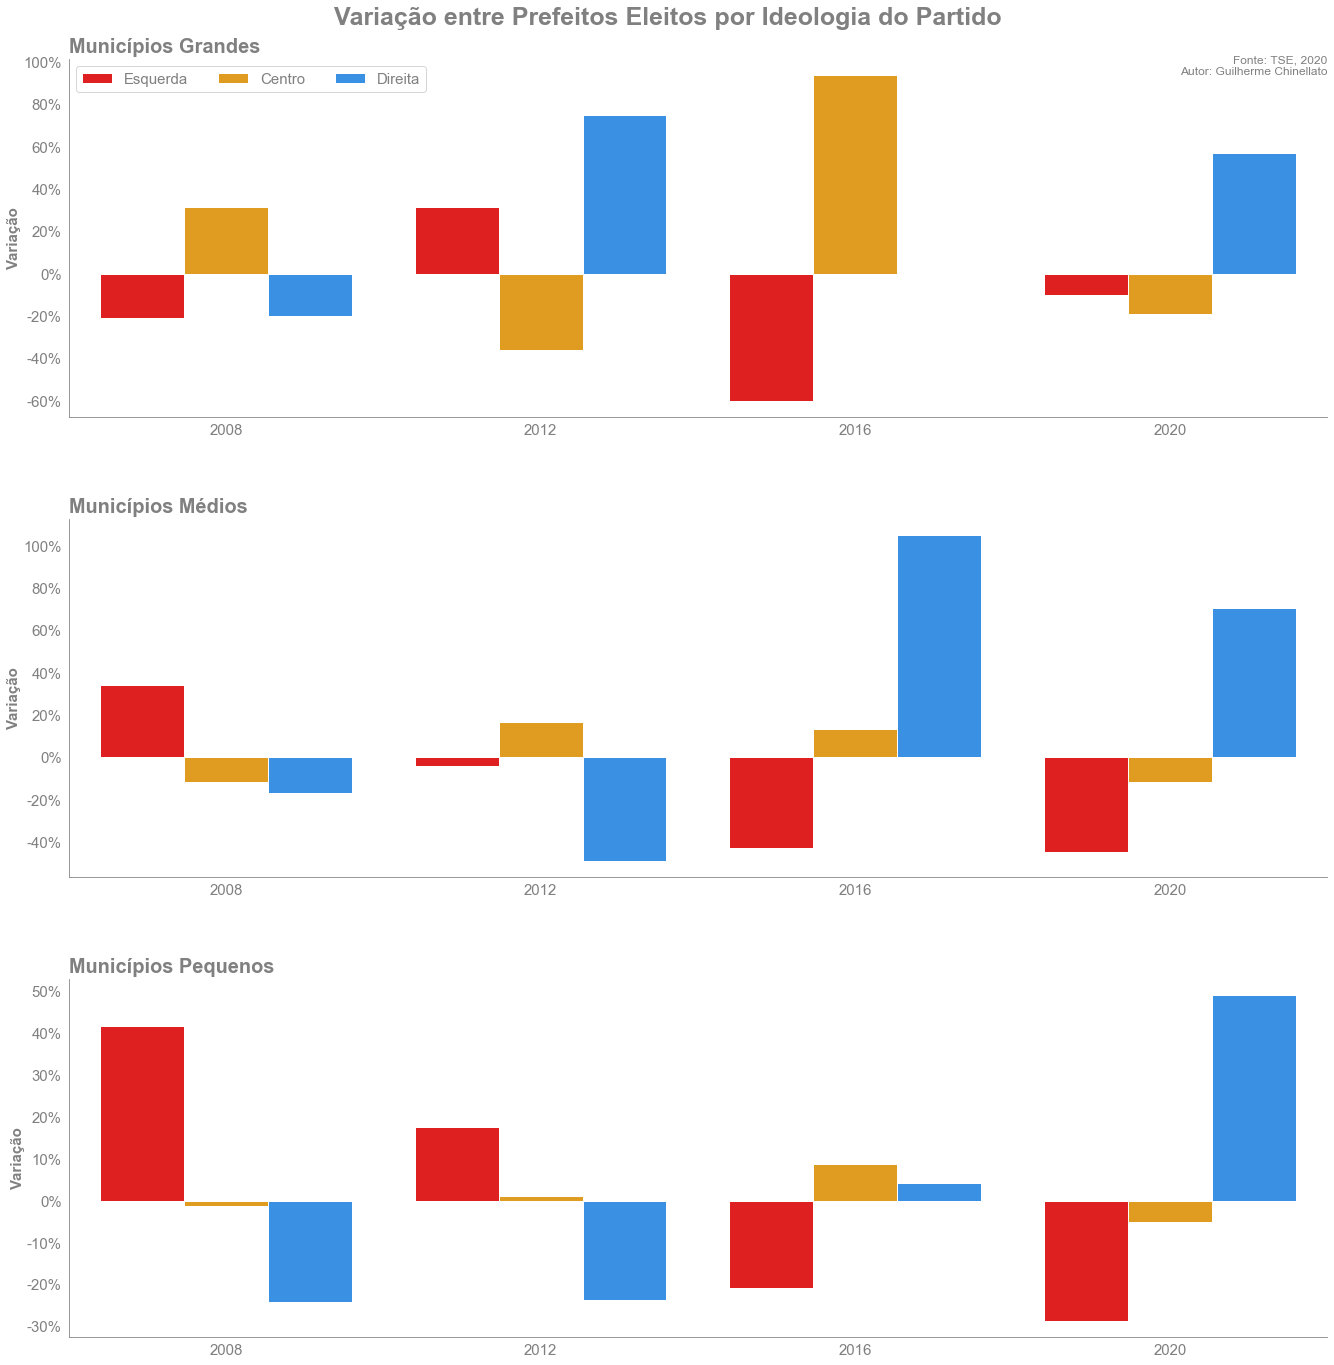

In [543]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

sns.set_style('whitegrid')
sns.despine()

c_grande = sns.catplot(data=agg_municipios_grandes_var, x='Ano', y='Variação', hue='Ideologia', kind='bar',
                      palette=colors, ax=axs[0])
c_medio = sns.catplot(data=agg_municipios_medios_var, x='Ano', y='Variação', hue='Ideologia', kind='bar'
                      , palette=colors, ax=axs[1])
c_pequeno = sns.catplot(data=agg_municipios_pequenos_var, x='Ano', y='Variação', hue='Ideologia', kind='bar'
                      , palette=colors, ax=axs[2])

fig.suptitle('Variação entre Prefeitos Eleitos por Ideologia do Partido', fontsize=25, fontweight='bold',
             color='grey')

axs[0].set_title('Municípios Grandes', loc='left', fontsize=20, fontweight='bold', color='grey')
axs[1].set_title('Municípios Médios', loc='left', fontsize=20, fontweight='bold', color='grey')
axs[2].set_title('Municípios Pequenos', loc='left', fontsize=20, fontweight='bold', color='grey')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

axs[0].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[1].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')
axs[2].set_ylabel('Variação', labelpad=2, fontsize=15, fontweight='bold', color='grey')

axs[0].set_xticklabels(labels=[ano_da_eleicao[i+1] for i in axs[0].get_xticks()], fontsize=15, color='grey')
axs[1].set_xticklabels(labels=[ano_da_eleicao[i+1] for i in axs[1].get_xticks()], fontsize=15, color='grey')
axs[2].set_xticklabels(labels=[ano_da_eleicao[i+1] for i in axs[2].get_xticks()], fontsize=15, color='grey')

vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')
vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')
vals = axs[2].get_yticks()
axs[2].set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=15, color='grey')

axs[0].spines['bottom'].set_color('grey')
axs[0].spines['left'].set_color('grey')
axs[1].spines['bottom'].set_color('grey')
axs[1].spines['left'].set_color('grey')
axs[2].spines['bottom'].set_color('grey')
axs[2].spines['left'].set_color('grey') 

l = axs[0].legend(loc='upper left', ncol=4, fontsize=15)
for text in l.get_texts():
    text.set_color('grey')
axs[1].get_legend().remove()
axs[2].get_legend().remove()

axs[0].text(1.0, 1.01, legend, transform=axs[0].transAxes, fontsize=12, ha='right', va='top', color='grey')

plt.close(2)
plt.close(3)
plt.close(4)
fig.tight_layout(pad=6)
plt.savefig('output/prefeitos_ideologia_var.png', dpi=300, bbox_inches = 'tight')

Correlação entre:
- Maiores Municípios vs Menores Municípios
- Maiores Municípios vs Capitais
- Menores Municípios vs Capitais

# Mapa Brasil

In [560]:
year=2020

In [563]:
df.columns

Index(['ano', 'sigla_unidade_federativa', 'codigo_municipio', 'numero_urna',
       'nome_municipio', 'numero_partido', 'sigla_partido',
       'composicao_legenda', 'nome_urna', 'total_votos', 'ideologia',
       'capitais', 'regiao', 'GEOCOD_IBGE', 'COD_TSE', 'AJUSTE', 'População',
       'densidade', 'grupo_densidade', 'latitude', 'longitude'],
      dtype='object')

In [565]:
df_temp = df[df.ano == year].drop_duplicates(subset='codigo_municipio', keep='first')
df_temp.drop(['ano','codigo_municipio','sigla_unidade_federativa','numero_partido',
             'sigla_partido','numero_urna','total_votos','GEOCOD_IBGE','COD_TSE','AJUSTE',
             'grupo_densidade'], axis=1, inplace=True)
df_temp = df_temp[['nome_municipio','ideologia','latitude','longitude','População','densidade']]

In [566]:
df_temp.to_excel('output/flourish_prefeitos_mapa_populacao_'+str(year)+'.xlsx')

Municipios Grandes que cada ideologia possui maioria

In [567]:
df_temp.sort_values('População', ascending=False, inplace=True)

In [568]:
df_temp[(df_temp['População'] > 500000)].head(10)

,nome_municipio,ideologia,latitude,longitude,População,densidade
3550308,SAO PAULO,Centro,-23.53290,-46.6395,12325232,8102.788096
3304557,RIO DE JANEIRO,Direita,-22.91290,-43.2003,6747815,5621.637901
2927408,SALVADOR,Direita,-12.97180,-38.5011,2886698,4162.788250
2304400,FORTALEZA,Esquerda,-3.71664,-38.5423,2686612,8601.204407
3106200,BELO HORIZONTE,Centro,-19.91020,-43.9266,2521564,7609.879464
1302603,MANAUS,Direita,-3.11866,-60.0212,2219580,194.681352
4106902,CURITIBA,Direita,-25.41950,-49.2646,1948626,4480.712453
2611606,RECIFE,Esquerda,-8.04666,-34.8771,1653461,7555.466704
5208707,GOIANIA,Centro,-16.68640,-49.2643,1536097,2107.588624
1501402,BELEM,Esquerda,-1.45540,-48.4898,1499641,1415.468736


In [569]:
df_temp[(df_temp['População'] > 500000) & (df_temp.ideologia == 'Esquerda')].head()

,nome_municipio,ideologia,latitude,longitude,População,densidade
2304400,FORTALEZA,Esquerda,-3.71664,-38.5423,2686612,8601.204407
2611606,RECIFE,Esquerda,-8.04666,-34.8771,1653461,7555.466704
1501402,BELEM,Esquerda,-1.45540,-48.4898,1499641,1415.468736
2704302,MACEIO,Esquerda,-9.66599,-35.7350,1025360,2013.194063
3118601,CONTAGEM,Esquerda,-19.93210,-44.0539,668949,3434.981977


In [570]:
df_temp[(df_temp['População'] > 500000) & (df_temp.ideologia == 'Centro')].head()

,nome_municipio,ideologia,latitude,longitude,População,densidade
3550308,SAO PAULO,Centro,-23.5329,-46.6395,12325232,8102.788096
3106200,BELO HORIZONTE,Centro,-19.9102,-43.9266,2521564,7609.879464
5208707,GOIANIA,Centro,-16.6864,-49.2643,1536097,2107.588624
4314902,PORTO ALEGRE,Centro,-30.0318,-51.2065,1488252,3004.202749
3518800,GUARULHOS,Centro,-23.4538,-46.5333,1392121,4368.466306


In [571]:
df_temp[(df_temp['População'] > 500000) & (df_temp.ideologia == 'Direita')].head()

,nome_municipio,ideologia,latitude,longitude,População,densidade
3304557,RIO DE JANEIRO,Direita,-22.91290,-43.2003,6747815,5621.637901
2927408,SALVADOR,Direita,-12.97180,-38.5011,2886698,4162.788250
1302603,MANAUS,Direita,-3.11866,-60.0212,2219580,194.681352
4106902,CURITIBA,Direita,-25.41950,-49.2646,1948626,4480.712453
2111300,SAO LUIS,Direita,-2.53874,-44.2825,1108975,1902.271799


Mapa do Brasil com quantidade de prefeitos eleitos com determinada ideologia do partido

In [573]:
df_novo = df.copy()
df_novo = df_novo[df_novo.ano == year].drop_duplicates(subset='codigo_municipio', keep='first')
df_novo['CD_GEOCMU'] = df_novo['GEOCOD_IBGE'].astype(str)

df_novo.drop(['ano','codigo_municipio','numero_partido',
             'sigla_partido','numero_urna','total_votos','GEOCOD_IBGE','COD_TSE','AJUSTE',
             'grupo_densidade'], axis=1, inplace=True)

In [574]:
df_mapa = gpd.read_file('input/geo/br_municipios/BRMUE250GC_SIR.shp')
df_mapa['NM_MUNICIP'] = df_mapa['NM_MUNICIP'].str.upper().apply(lambda x: unidecode(x))

df_mapa_novo = pd.merge(df_mapa, df_novo, how='left', on='CD_GEOCMU')
df_mapa_novo.set_index('CD_GEOCMU', inplace=True)
df_mapa_novo.dropna(inplace=True)

In [575]:
df_mapa_uf = gpd.read_file('input/geo/br_unidades_da_federacao/BR_UF_2019.shp')

df_novo_uf = df_novo.groupby(['sigla_unidade_federativa','ideologia'])['CD_GEOCMU'].count().unstack().reset_index()
df_novo_uf['max'] = df_novo_uf[['Centro','Direita','Esquerda']].idxmax(axis=1)

df_mapa_uf_novo = pd.merge(df_mapa_uf, df_novo_uf, left_on='SIGLA_UF', right_on='sigla_unidade_federativa')
df_mapa_uf_novo.dropna(inplace=True)

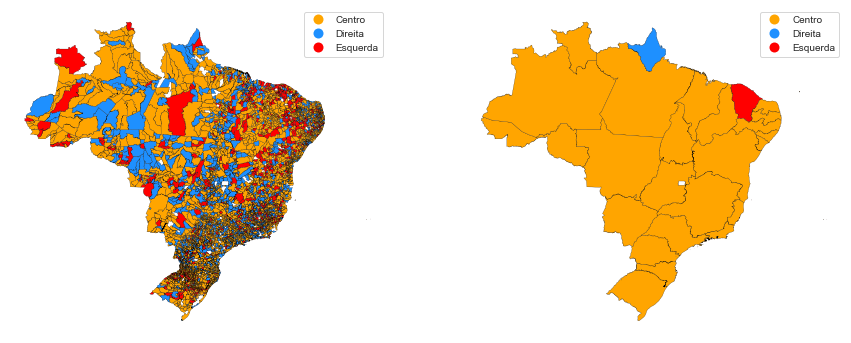

In [577]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

p1 = df_mapa_novo.plot(column='ideologia', cmap=ListedColormap(['orange','dodgerblue','red']), legend=True, linewidth=0.2, ax=axs[0], edgecolor='black')
p2 = df_mapa_uf_novo.plot(column='max', cmap=ListedColormap(['orange','dodgerblue','red']), legend=True, linewidth=0.2, ax=axs[1], edgecolor='black')

p1.set_axis_off()
p2.set_axis_off()

fig.savefig('output/prefeitos_brasil_municipios_'+str(year)+'.png', dpi=300, bbox_inches = 'tight')